In [10]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import math
import itertools

## Multivariable

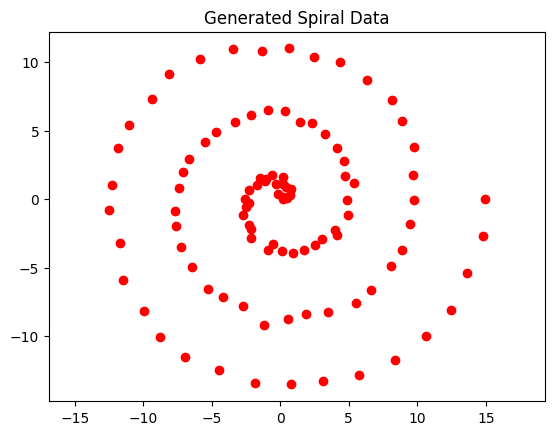

In [11]:
# Parameters for the spiral
num_points = 100  # Number of points
num_turns = 3     # Number of spiral turns
noise = 0.2       # Noise level

# Generate the angles for the spiral
theta = np.linspace(0, num_turns * 2 * np.pi, num_points)

# Generate the radii (distance from origin)
r = np.linspace(0, 15, num_points)

# Convert polar coordinates (r, theta) to Cartesian coordinates (x, y)
x = r * np.cos(theta)
y = r * np.sin(theta)

# Add noise to the data
x += np.random.normal(0, noise, num_points)
y += np.random.normal(0, noise, num_points)

x_0 = np.vstack((x, y)).T

# Plot the spiral
plt.scatter(x, y, color='red')
plt.axis('equal')
plt.title('Generated Spiral Data')
plt.show()

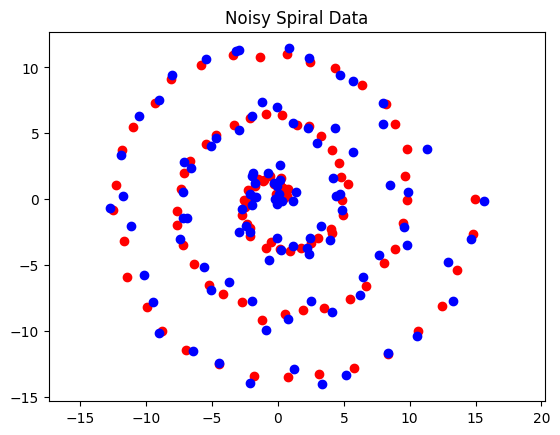

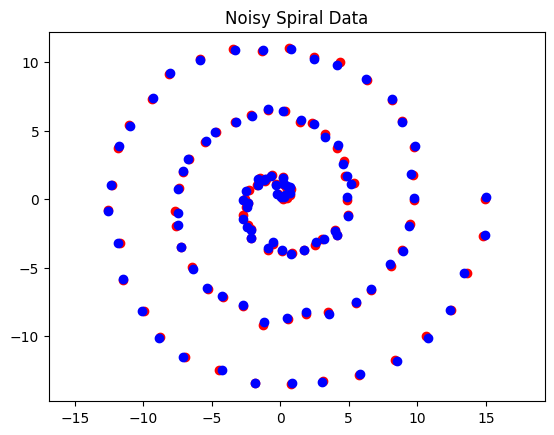

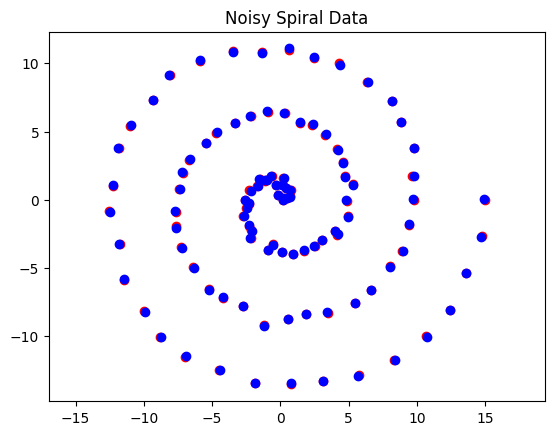

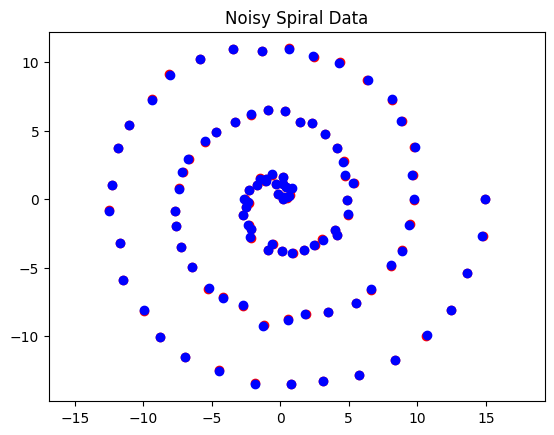

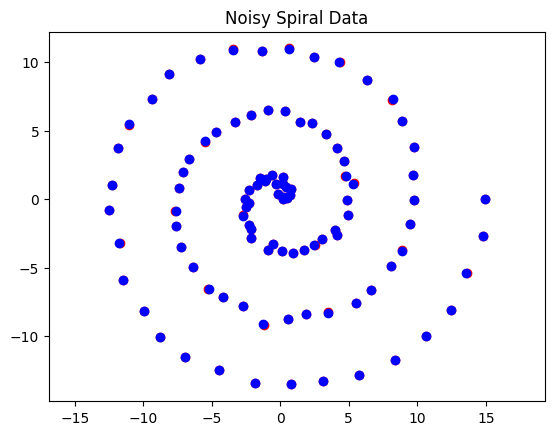

In [12]:
# Add noise to the data
noise_level = [0.5, 0.1, 0.05, 0.03, 0.01]

training_data = []
label_matrix = []

x = x_0.copy()

for epsilon in noise_level:
    gaussian_noise = np.random.multivariate_normal([0, 0], np.eye(2), num_points)
    x = x_0 + epsilon * gaussian_noise
    label_matrix.append(gaussian_noise)
    training_data.append(x)

    plt.scatter(x_0[:, 0], x_0[:, 1], color='red', label='Original')
    plt.scatter(x[:, 0], x[:, 1], color='blue', label='Noisy')
    plt.axis('equal')
    plt.title('Noisy Spiral Data')
    plt.show()

# # reverse the order of the training data
# training_data = training_data[::-1]
# label_matrix = label_matrix[::-1]

In [13]:
N = 100  # number of data samples
D = 2   # dimensions of data
C = math.comb(N, D-1)  # number of combinations of N choose D-1

In [14]:
# find K matrix from the given data, see Theorem F.2
def find_K(x: np.ndarray) -> np.ndarray:
    K = np.zeros((N, C))
    row_idx = np.arange(N)

    # Generate possible combinations of d-1 elements from n elements
    idx_combinations = list(itertools.combinations(row_idx, D-1))

    for i in range(N):
        x_i = x[i]
        for j in range(C):
            x_j = x[idx_combinations[j]]
            
            # Compute outer product of every row in x_j and take L1 norm
            denominator = np.linalg.norm(x_j, ord=1)
            # print("denominator: ", denominator)

            numerator = np.cross(x_i, x_j)
            numerator = np.maximum(numerator, 0)

            K[i, j] = numerator / denominator

    return K

K_list = []
for x in training_data:
    K_list.append(find_K(x))

/tmp/ipykernel_158977/323016616.py:18: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  numerator = np.cross(x_i, x_j)


In [15]:
# Solve Eq 33
Z_list = []

for i in range(len(noise_level)):
    epsilon = noise_level[i]
    print(f'Noise level: {epsilon}')
    # l is label matrix
    l = label_matrix[i]
    # l = np.random.multivariate_normal([0, 0], np.eye(2), C)
    l = l / epsilon # Still not sure if it should be division or multiplication

    reg_lambda = 0.1
    z = cp.Variable((C, D))

    # Define the optimization problem
    # regularization_term = reg_lambda * cp.sum([cp.norm(z[i, :], 1) for i in range(C)]) # Modified to the norm over row
    regularization_term = reg_lambda * cp.sum([cp.norm(z[:, i], 2) for i in range(D)]) # Following paper notation of norm over column
    objective = cp.Minimize(cp.norm(K_list[i] @ z - l, 'fro')**2 + regularization_term)

    # Solve the optimization problem
    problem = cp.Problem(objective)
    problem.solve(solver='MOSEK')

    # Extract the optimal value and optimal Z
    optimal_value = problem.value
    optimal_Z = z.value
    Z_list.append(optimal_Z)

    print(f'Optimal value: {optimal_value}')
    print(f'Optimal Z: {optimal_Z}')

Noise level: 0.5
Optimal value: 177.86812182419976
Optimal Z: [[-8.99122928e-01  4.75968132e+01]
 [ 2.22517763e+01  1.61722554e+01]
 [ 8.92764181e+00 -3.53230623e+00]
 [-6.01561141e+01  6.32626914e+01]
 [-5.07239097e+01 -7.17995044e+01]
 [-7.89378769e+00 -1.84195139e+01]
 [-6.03233968e+01 -2.23872951e+01]
 [-1.52027164e-01  1.48057129e+01]
 [-8.88364367e-01  8.44202385e+00]
 [-1.80006140e+01 -2.11288696e+00]
 [-6.99258366e+01 -6.69296865e+01]
 [ 7.15911130e+01 -4.56771435e+01]
 [-3.70504235e+01 -4.81369016e+01]
 [ 5.84217711e+01 -3.41422873e+00]
 [-1.47859505e+01 -1.46301786e+01]
 [ 2.52355436e+01  5.16775330e+01]
 [-6.77571669e+01  7.69110825e+01]
 [ 7.72838182e+00 -7.86009762e+00]
 [-5.29128301e+01 -7.39141222e+01]
 [ 5.57646228e+01 -7.33954450e+01]
 [ 5.51729937e+01  6.53068630e+01]
 [ 1.01636056e+01  7.03709892e+01]
 [ 3.70927206e+01 -6.87605494e+01]
 [-3.44163145e+01  8.56815269e+01]
 [ 2.33627094e+00  9.69898732e+00]
 [-2.79518106e+00  3.40887466e+00]
 [-8.12556327e+00 -3.7081461

In [16]:
# Achieve NN
# They fucked up the notation in Eq 34..., 
# We should look Eq 48 of arxiv.org/pdf/2309.16512 
# I'm interpreting Z_j as the j-th row of Z, and x_i as x, and x_j as row in training data
def NN(x: np.ndarray, optimal_Z: np.ndarray, training_data: np.ndarray) -> np.ndarray:
    output = np.zeros_like(x)

    for j in range(C):
        Z_j = optimal_Z[j]
        x_j = training_data[j]
        
        numerator = np.cross(x, x_j)
        numerator = np.maximum(numerator, 0)

        denominator = np.linalg.norm(x_j, ord=1)

        output += Z_j * (numerator / denominator)

    return output


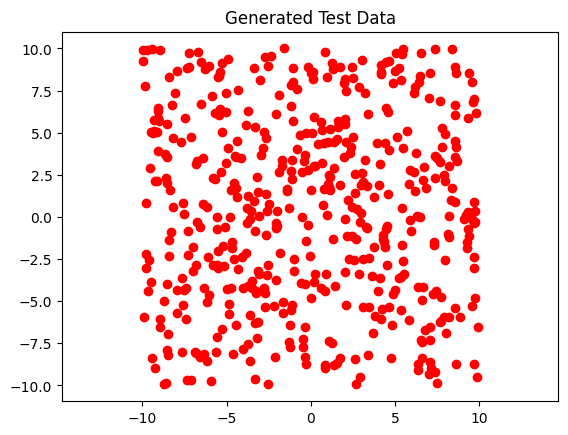

/tmp/ipykernel_158977/1015933238.py:12: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  numerator = np.cross(x, x_j)


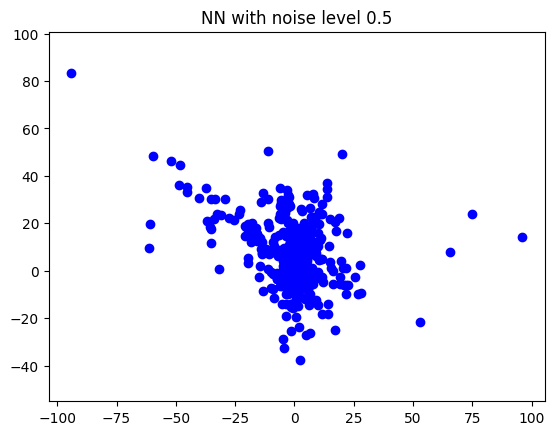

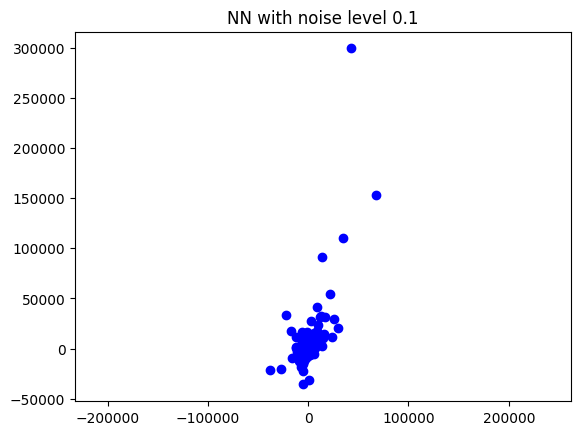

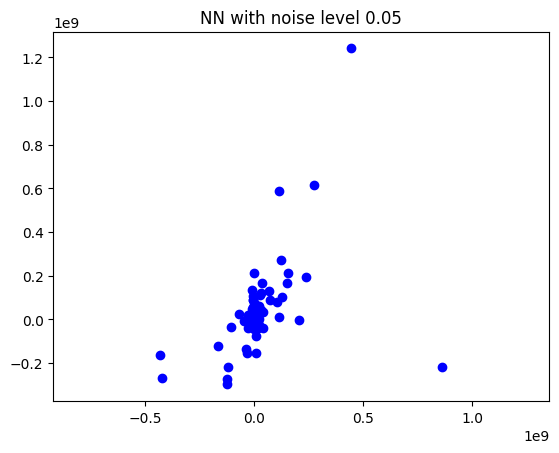

In [ ]:
# Sample
x_T = np.random.uniform(-10, 10, (500, 2))

plt.scatter(x_T[:, 0], x_T[:, 1], color='red', label='Original')
plt.axis('equal')
plt.title('Generated Test Data')
plt.show()

steps_per_noise = [5, 5, 5, 5, 15]

x = x_T.copy()
eta = 1

for i in range(5):
    optimal_Z = Z_list[i]
    epsilon = noise_level[i]

    for j in range(steps_per_noise[i]):
        for k in range(x.shape[0]):
            NN_output = NN(x[k], optimal_Z, training_data[i])
            z_t = np.random.multivariate_normal(mean=np.zeros(2), cov=epsilon*np.eye(D))
            x[k] = x[k] + eta*NN_output + np.sqrt(2*eta)*z_t

    plt.scatter(x[:, 0], x[:, 1], color='blue', label='Diffusion')
    plt.axis('equal')
    plt.title(f'NN with noise level {epsilon}')
    plt.show()